In [1]:
import sklearn
import lightgbm
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
housing_df = pd.read_csv('housing_dataset.csv')

## Removing Columns with lot of missing values

In [3]:
filtered_columns = [col for col in housing_df.columns if col.lower() not in ['id']]
housing_filtered = housing_df[filtered_columns]
cutoff = 0.4
missing_vals = housing_filtered.isnull().sum().sort_values()
missing_vals_reduced = missing_vals[missing_vals != 0]

columnswith_many_missing_values = missing_vals_reduced[missing_vals_reduced>cutoff*len(housing_df)].index.values
print (f"{columnswith_many_missing_values} have missing values for more {cutoff*100}% of the dataset")

['FireplaceQu' 'Fence' 'Alley' 'MiscFeature' 'PoolQC'] have missing values for more 40.0% of the dataset


In [4]:
filter_columns = columnswith_many_missing_values.tolist()

In [5]:
housing_filtered['log_sales'] = np.log(housing_filtered['SalePrice'])

In [6]:
housing_filtered_2 = housing_filtered[[col for col in housing_filtered.columns if col not in filter_columns ]]
final_housing_df = housing_filtered_2.dropna()

## Prepare train and test split

In [7]:
X = final_housing_df[[col for col in housing_filtered_2.columns if col not in ['SalePrice', 'log_sales']]]

In [8]:
Y = final_housing_df['SalePrice']

In [9]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

In [10]:
le = defaultdict(LabelEncoder)

In [11]:
X['SaleType'].dtype.name

'object'

In [12]:
X_encoded = X.apply(lambda x: le[x.name].fit_transform(x) if x.dtype.name not in ['int64', 'float64'] else x)

In [13]:
X_encoded

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,68.0,11250,1,0,3,0,4,0,...,42,0,0,0,0,0,9,2008,8,4
3,70,3,60.0,9550,1,0,3,0,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,60,3,84.0,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,3,3,0,4,0,...,40,0,0,0,0,0,8,2007,8,4
1456,20,3,85.0,13175,1,3,3,0,4,0,...,0,0,0,0,0,0,2,2010,8,4
1457,70,3,66.0,9042,1,3,3,0,4,0,...,60,0,0,0,0,2500,5,2010,8,4
1458,20,3,68.0,9717,1,3,3,0,4,0,...,0,112,0,0,0,0,4,2010,8,4


In [14]:
trainx, testx, trainy, testy = train_test_split(X_encoded,Y,test_size=0.3, random_state=42)

## XGBoost Model

In [15]:
import xgboost as xgb
from xgboost import XGBRegressor

In [16]:
def fetch_df_row(df, index):
    return pd.DataFrame(testx.loc[index].values.reshape(1,len(df.columns)), columns = df.columns)

In [17]:
trainx

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
857,60,3,65.0,8125,1,3,3,0,4,0,...,36,0,0,0,0,0,3,2009,8,4
1391,90,3,65.0,8944,1,3,3,0,4,0,...,152,0,0,0,0,0,4,2009,8,4
329,70,4,60.0,6402,1,3,3,0,0,0,...,0,137,0,0,0,0,7,2009,8,4
1052,60,3,100.0,9500,1,3,3,0,0,0,...,52,0,0,0,0,0,6,2007,8,4
630,70,4,50.0,9000,1,3,3,0,0,0,...,0,293,0,0,0,0,6,2006,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,30,3,40.0,4280,1,3,3,0,4,0,...,0,34,0,0,0,0,3,2007,8,4
609,20,3,61.0,7943,1,3,3,0,4,0,...,0,39,0,0,0,0,4,2007,8,4
171,20,3,141.0,31770,1,0,3,0,0,0,...,62,0,0,0,0,0,5,2010,8,4
1395,60,3,88.0,12665,1,0,3,0,4,0,...,39,0,0,0,0,0,2,2007,8,4


In [18]:
train_data = xgb.DMatrix(trainx, label=trainy)

In [19]:
param = {}
param['nthread'] = 4
param['eval_metric'] = 'auc'

In [20]:
model = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42, n_jobs=-1, **param)
model.fit(trainx, trainy)
# bst = xgb.train(param, train_data, num_round)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, eval_metric='auc',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=-1,
             nthread=4, num_parallel_tree=1, random_state=42, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=42, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
import eli5

/Users/mayorao/opt/miniconda3/envs/stats/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/mayorao/opt/miniconda3/envs/stats/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [22]:
eli5.explain_weights_xgboost(model)

Weight,Feature
0.1846,GarageCars
0.1784,Condition2
0.1266,OverallQual
0.1152,ExterQual
0.0689,BsmtQual
0.0425,CentralAir
0.0413,KitchenQual
0.0338,FullBath
0.0220,PoolArea
0.0193,LandContour


In [23]:
# model.predict(testx.iloc[0].values.reshape(1,74))
testx

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
634,90,3,64.0,6979,1,3,3,0,4,0,...,56,0,0,0,0,600,6,2010,8,4
194,20,3,60.0,7180,1,0,3,0,4,0,...,0,0,0,0,0,0,5,2008,8,4
117,20,3,74.0,8536,1,3,3,0,0,0,...,64,0,0,0,0,0,4,2007,6,5
1249,20,3,60.0,7200,1,3,3,0,4,0,...,80,0,0,0,0,0,5,2007,8,4
969,190,3,75.0,10382,1,3,3,0,4,0,...,0,0,0,0,0,0,3,2006,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,20,3,150.0,215245,1,2,2,0,4,2,...,0,0,0,0,0,0,6,2009,8,4
558,60,3,57.0,21872,1,1,1,0,2,0,...,22,0,0,0,0,0,8,2008,8,4
776,20,3,86.0,11210,1,0,3,0,4,0,...,59,0,0,0,0,0,7,2006,6,5
408,60,3,109.0,14154,1,3,3,0,0,0,...,62,0,0,0,0,0,8,2007,6,5


In [24]:
testy

634     144000
194     127000
117     155000
1249    119000
969     140000
         ...  
313     375000
558     175000
776     221500
408     280000
467     146500
Name: SalePrice, Length: 329, dtype: int64

In [25]:
trainy.min()

35311

In [26]:
print (model.predict(fetch_df_row(testx, 502)), testy.loc[502])

[142998.19] 140000


In [28]:
print (model.predict(fetch_df_row(testx, 1249)), testy.loc[1249])

[125448.63] 119000


In [29]:
fetch_df_row(testx, 502)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20.0,3.0,70.0,9170.0,1.0,3.0,3.0,0.0,0.0,0.0,...,0.0,184.0,0.0,0.0,0.0,400.0,4.0,2007.0,8.0,4.0


In [42]:
fetch_df_row(testx, 502)[testx.columns[[16,41,36,2,32,44,15]]]

,OverallCond,1stFlrSF,TotalBsmtSF,LotFrontage,BsmtFinSF1,GrLivArea,OverallQual
0,7.0,1214.0,1214.0,70.0,698.0,1214.0,5.0


In [31]:
eli5.xgboost.explain_prediction_xgboost(model, doc=fetch_df_row(testx, 502))

Explanation(estimator="XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n             colsample_bynode=1, colsample_bytree=0.4, eval_metric='auc',\n             gamma=0, gpu_id=-1, importance_type='gain',\n             interaction_constraints='', learning_rate=0.07, max_delta_step=0,\n             max_depth=3, min_child_weight=1.5, missing=nan,\n             monotone_constraints='()', n_estimators=10000, n_jobs=-1,\n             nthread=4, num_parallel_tree=1, random_state=42, reg_alpha=0.75,\n             reg_lambda=0.45, scale_pos_weight=1, seed=42, subsample=0.6,\n             tree_method='exact', validate_parameters=1, verbosity=None)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=184983.90406998261, std=None, value=1.0), FeatureWeight(feature='x16', weight=5883.409200494462, std=None, value=7.0), FeatureWeight(feature='x41', weight=4260.6971957944215, std=None, value=1214.0), FeatureWeight(feature='x36', weight=2610.068143444918, std=None, value=1214.0), FeatureWeight(feature='x2', weight=1280.601091726159, std=None, value=70.0), FeatureWeight(feature='x32', weight=1095.6480896604576, std=None, value=698.0), FeatureWeight(feature='x45', weight=985.9481389734026, std=None, value=1.0), FeatureWeight(feature='x8', weight=944.9642059902534, std=None, value=0.0), FeatureWeight(feature='x65', weight=833.5044401655415, std=None, value=184.0), FeatureWeight(feature='x31', weight=750.2554120399633, std=None, value=0.0), FeatureWeight(feature='x52', weight=739.1805154211403, std=None, value=6.0), FeatureWeight(feature='x21', weight=505.4420730016895, std=None, value=7.0), FeatureWeight(feature='x39', weight=471.09448777953804, std=None, value=1.0), FeatureWeight(feature='x56', weight=461.73058922024256, std=None, value=1965.0), FeatureWeight(feature='x22', weight=425.6741688382917, std=None, value=8.0), FeatureWeight(feature='x71', weight=369.53187998280623, std=None, value=2007.0), FeatureWeight(feature='x53', weight=359.8287836198152, std=None, value=5.0), FeatureWeight(feature='x0', weight=323.819093624069, std=None, value=20.0), FeatureWeight(feature='x73', weight=253.51465827527034, std=None, value=4.0), FeatureWeight(feature='x26', weight=230.99348201194533, std=None, value=3.0), FeatureWeight(feature='x23', weight=211.4152451757645, std=None, value=2.0), FeatureWeight(feature='x55', weight=208.92300838754207, std=None, value=5.0), FeatureWeight(feature='x49', weight=173.19044106477662, std=None, value=2.0), FeatureWeight(feature='x62', weight=161.55055487625276, std=None, value=2.0), FeatureWeight(feature='x19', weight=134.6431456835018, std=None, value=3.0), FeatureWeight(feature='x24', weight=131.4617814672677, std=None, value=0.0), FeatureWeight(feature='x50', weight=126.31412787408709, 

# Explain Using Shap

In [33]:
import shap
shap.initjs()

In [34]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(trainx)

In [35]:
shap.force_plot(explainer.expected_value, shap_values[0,:], trainx.iloc[0,:])

In [36]:
shap.force_plot(explainer.expected_value, shap_values, trainx)

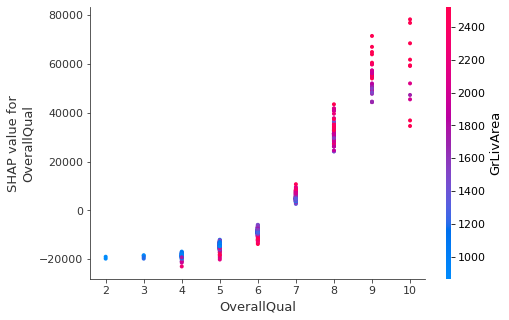

In [38]:
shap.dependence_plot("OverallQual", shap_values, trainx)

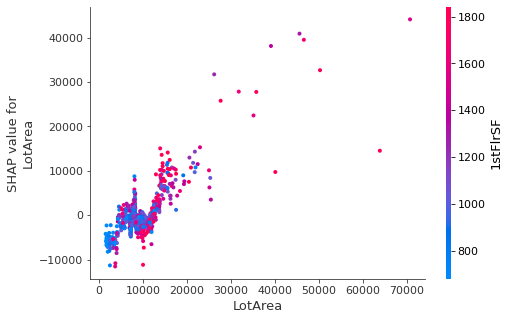

In [39]:
shap.dependence_plot("LotArea", shap_values, trainx)

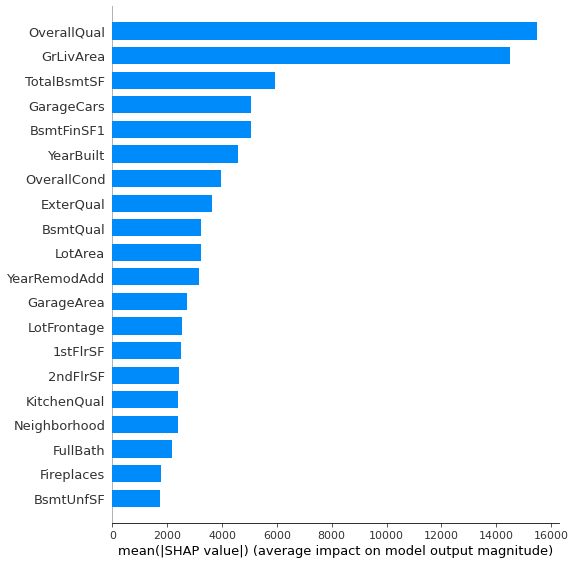

In [40]:
shap.summary_plot(shap_values, trainx, plot_type="bar")

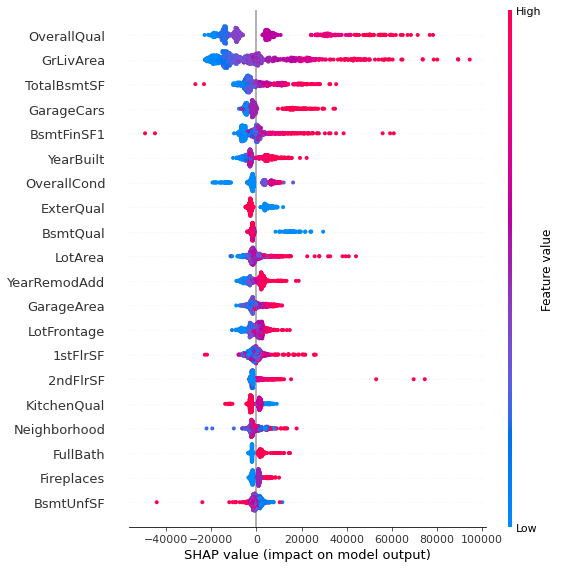

In [41]:
shap.summary_plot(shap_values, trainx)